<a href="https://colab.research.google.com/github/Maryam-Afshari/thesis/blob/master/LR_Basel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# checking out the GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun 13 07:54:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# checking out the memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Basel Station 

### reading data

In [ ]:
!pip install hydroeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import hydroeval as he
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df_b = pd.read_csv('/content/drive/MyDrive/Thesis-Afshari/data/basel.csv',index_col=0)
pred_basel= pd.read_csv('/content/drive/MyDrive/Thesis-Afshari/data/basel.csv',index_col=0)
# pred_basel = pred_basel.set_index("datetime")

In [ ]:
q_basel = pd.read_csv("/content/drive/MyDrive/Thesis-Afshari/data/q_basel.csv",index_col=0)


### Feature Engineering

In [ ]:
# making 60 lagged variables

TIME_STEPS = 60
is_lag = TIME_STEPS > 1
if is_lag:
  #add the lagged variables to the dataframe
  for i, var in enumerate(pred_basel[["et","p","t"]]):
    for step in range(0, TIME_STEPS - 1):
      pred_basel.insert(i*(TIME_STEPS) + 1,
                        f'{var}_lag_{TIME_STEPS - 1 - step}',
                        pred_basel[var].shift(TIME_STEPS - 1 - step))

#remove the first TIME_STEPS - 1 rows since they will contain NA values
pred_basel = pred_basel.iloc[TIME_STEPS - 1:,:].reset_index(drop=True)
q_basel = q_basel.iloc[TIME_STEPS - 1:,:].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if self.run_code(code, result):


In [ ]:
pred_basel.head()

,datetime,et_lag_1,et_lag_2,et_lag_3,et_lag_4,et_lag_5,et_lag_6,et_lag_7,et_lag_8,et_lag_9,...,t_lag_52,t_lag_53,t_lag_54,t_lag_55,t_lag_56,t_lag_57,t_lag_58,t_lag_59,t,obs
0,1981-03-01,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,0.000593,0.000569,0.000547,...,-10.731832,-6.366458,-2.218504,-2.055391,1.019687,5.165919,2.172385,-0.250816,0.190717,608.0
1,1981-03-02,0.000738,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,0.000593,0.000569,...,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,1.019687,5.165919,2.172385,2.494925,611.0
2,1981-03-03,0.000870,0.000738,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,0.000593,...,-5.646553,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,1.019687,5.165919,2.197226,766.0
3,1981-03-04,0.000855,0.000870,0.000738,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,...,-5.925995,-5.646553,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,1.019687,0.607470,871.0
4,1981-03-05,0.000767,0.000855,0.000870,0.000738,0.000826,0.000789,0.000738,0.000738,0.000706,...,-5.499934,-5.925995,-5.646553,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,0.910740,835.0


### Train-Test Split

In [ ]:
#define number of observations and the train split proportion
# predictors and output var
len_ = int(0.75 * pred_basel.shape[0])

df_train = pred_basel[:len_]
df_test = pred_basel[len_:]

# x train without lagged vars
X_train = df_train[["et","t","p"]]

# x train with lagged vars
X_train_lagged = df_train.drop(columns = ["obs","datetime"], axis =1)
y_train = df_train.obs

# x test without lagged vars
X_test = df_test[["et","t","p"]]

# x test with lagged vars
X_test_lagged = df_test.drop(columns = ["obs","datetime"], axis =1)
y_test = df_test.obs

In [ ]:
X_train_lagged.head()

,et_lag_1,et_lag_2,et_lag_3,et_lag_4,et_lag_5,et_lag_6,et_lag_7,et_lag_8,et_lag_9,et_lag_10,...,t_lag_51,t_lag_52,t_lag_53,t_lag_54,t_lag_55,t_lag_56,t_lag_57,t_lag_58,t_lag_59,t
0,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,0.000593,0.000569,0.000547,0.000532,...,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,1.019687,5.165919,2.172385,-0.250816,0.190717
1,0.000738,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,0.000593,0.000569,0.000547,...,-5.646553,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,1.019687,5.165919,2.172385,2.494925
2,0.000870,0.000738,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,0.000593,0.000569,...,-5.925995,-5.646553,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,1.019687,5.165919,2.197226
3,0.000855,0.000870,0.000738,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,0.000593,...,-5.499934,-5.925995,-5.646553,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,1.019687,0.607470
4,0.000767,0.000855,0.000870,0.000738,0.000826,0.000789,0.000738,0.000738,0.000706,0.000644,...,-4.769065,-5.499934,-5.925995,-5.646553,-8.999503,-10.731832,-6.366458,-2.218504,-2.055391,0.910740


### Normalising data

In [ ]:
# normalising for without lagged

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# normalising data with lagged
scaler_lagged = MinMaxScaler()

X_train_lagged = scaler_lagged.fit_transform(X_train_lagged)

X_test_lagged = scaler_lagged.transform(X_test_lagged)

### Model

In [ ]:
# creating an object of LinearRegression class
lm = LinearRegression()

# fitting the training data
lm.fit(X_train,y_train)

#evaluate the model
lm.score(X_test, y_test)

0.12075166081013522

In [ ]:
# creating an object of LinearRegression class
lm_lag = LinearRegression()

# fitting the training data
lm_lag.fit(X_train_lagged,y_train)

#evaluate the model
lm_lag.score(X_test_lagged, y_test)

0.6796257969848057

### Evaluation

In [ ]:
streamflow_pcr = q_basel.pcr[len_:]

# evaluate pcr model using nse and kge
nse_pcr = he.evaluator(he.nse, streamflow_pcr,y_test)
kge_pcr, r_pcr, alpha_pcr, beta_pcr = he.evaluator(he.kge, streamflow_pcr, y_test)
print("The nse and kge of the PCR model are {:.2} and {:.2} respectively.".format(nse_pcr[0], kge_pcr[0]))

# predicting for model with only meteorological variables
y_pred =  lm.predict(X_test)

# predicting for model with meteorological variables + lagged variables
y_pred_lagged = lm_lag.predict(X_test_lagged)

# evaluate the prediction using nse and kge for model with only meteorological variables
nse = he.evaluator(he.nse, y_pred, y_test)
kge, r, alpha, beta = he.evaluator(he.kge, y_pred, y_test)

# evaluate the prediction using nse and kge for model with meteorological variables + lagged variables
nse_lag = he.evaluator(he.nse, y_pred_lagged, y_test)
kge_lag, r_lag, alpha_lag, beta_lag = he.evaluator(he.kge, y_pred_lagged, y_test)
print("The nse and kge of the linear model are {:.2} and {:.2} respectively.".format(nse[0], kge[0]))
print("The nse and kge of the linear model including lagged variables are {:.2} and {:.2} respectively.".format(nse_lag[0], kge_lag[0]))

The nse and kge of the PCR model are 0.22 and 0.64 respectively.
The nse and kge of the linear model are 0.12 and 0.12 respectively.
The nse and kge of the linear model including lagged variables are 0.68 and 0.72 respectively.


### Plots

In [ ]:
print(streamflow_pcr.shape, y_test.shape, y_pred.shape)


(1812,) (1812,) (1812,) (1812,)


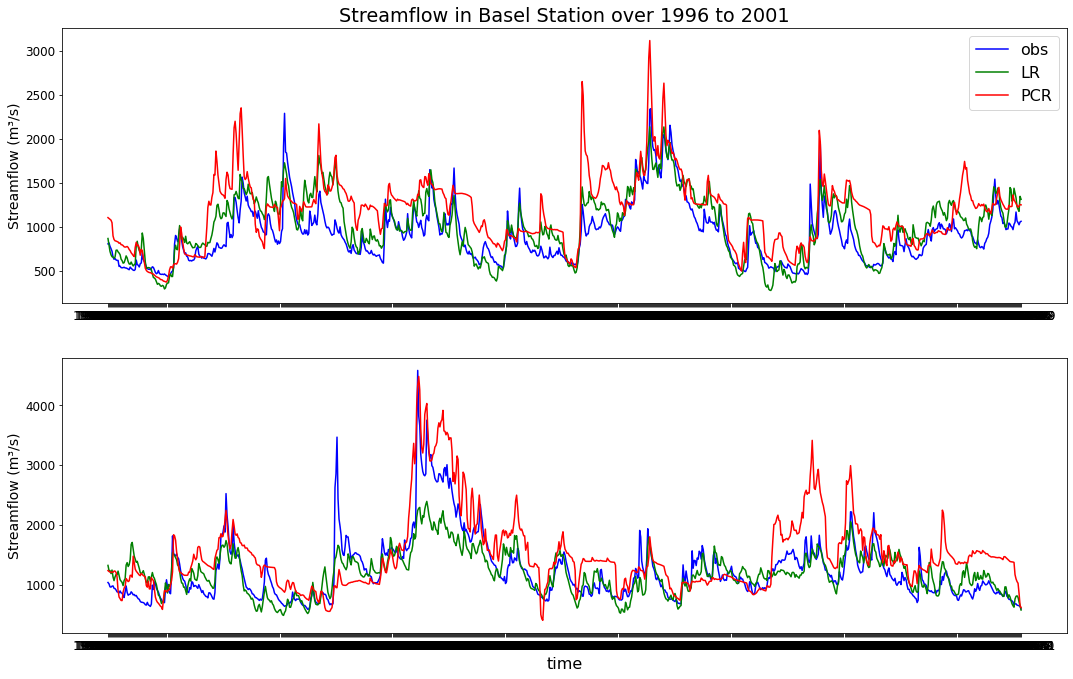

In [ ]:
# plot performance of model for year 1996-2000 and 2000-2001 in two different subplots

### TO DO: DATE IS NOT CORRECT HERE, HOW TO PLOT IT CORRECTLY?## 

# variables to plot
Y_test = y_test
predicted = y_pred_lagged
pcr_prediction = streamflow_pcr
date = pred_basel.datetime[len_:]

# years to plot
date_1 = date[:906]  # half of y_test value which is 1812
date_2 = date[906:]

# dividing variables to two years
actual_1 = Y_test[:906]
actual_2 = Y_test[906:]

predicted_1 = predicted[:906]
predicted_2 = predicted[906:]

pcr_prediction_1 = pcr_prediction[:906]
pcr_prediction_2 = pcr_prediction[906:]

# plot the variables
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(18, 18*2/(1+5**0.5)))
ax1.plot(date_1, actual_1, "b",label ="obs")
ax1.plot(date_1, predicted_1, "g", label = "LR")
ax1.plot(date_1, pcr_prediction_1,"r", label = "PCR")

ax2.plot(date_2, actual_2,"b")
ax2.plot(date_2, predicted_2,"g")
ax2.plot(date_2, pcr_prediction_2, "r")

# #set the ticks
# days_per_year = [0]+[365, 365, 365, 366]*5
# ticks = np.cumsum(days_per_year[:-1])[:int(20*shown_data)]

#tweak the axes
ax1.title.set_text('Streamflow in Basel Station over 1996 to 2001')
ax2.set_xlabel('time')
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 14) # maybe change the range of y axis so that you do not see so many variation
ax2.set_ylabel('Streamflow (m³/s)', fontsize = 14)
ax1.legend()

for ax in (ax1, ax2):
  #ax.grid(axis = 'y')
  ax.tick_params(axis='y', labelsize=12)
  ax.tick_params(axis='x', labelsize=12)
  #ax.set_yticks(ticks= [1000,2000,3000,4000])

plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/1996-2001_basel_LR.png")